### Notebook to train the background Kernel Density Estimates for Bayesian inference 

In [1]:
%matplotlib inline
from sklearn.neighbors.kde import KernelDensity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import pickle as p
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import warnings

In [2]:
#read in the combined photometric data:
catalog_1 = pd.read_csv('ngvs_bg1_phot_combined.csv')
catalog_1['cat'] = 1
catalog_2 = pd.read_csv('ngvs_bg2_phot_combined.csv')
catalog_2['cat'] = 2
catalog_3 = pd.read_csv('ngvs_bg3_phot_combined.csv')
catalog_3['cat'] = 3

In [3]:
catalog_2_i = catalog_2.ix[(catalog_2['i_mag'] < 90) & (catalog_2['i_flags'] < 1)]

### Include only sources detected in all three filters.

In [4]:
#only use data selcted with all three filters with no flags
all_detected_1 = (catalog_1['g_mag'] < 90) & (catalog_1['r_mag'] < 90) & (catalog_1['i_mag'] < 90) & \
    (catalog_1['g_flags'] < 1) & (catalog_1['r_flags'] < 1) & (catalog_1['i_flags'] < 1)
    
all_detected_2 = (catalog_2['g_mag'] < 90) & (catalog_2['r_mag'] < 90) & (catalog_2['i_mag'] < 90) & \
(catalog_2['g_flags'] < 1) & (catalog_2['r_flags'] < 1) & (catalog_2['i_flags'] < 1) & (catalog_2['i_merr'] < 0.1)

all_detected_3 = (catalog_3['g_mag'] < 90) & (catalog_3['r_mag'] < 90) & (catalog_3['i_mag'] < 90) & \
(catalog_3['g_flags'] < 1) & (catalog_3['r_flags'] < 1) & (catalog_3['i_flags'] < 1)

catalog_1_detected_only = catalog_1.ix[all_detected_1,:]
catalog_2_detected_only = catalog_2.ix[all_detected_2,:]
catalog_3_detected_only = catalog_3.ix[all_detected_3,:]

#also need to correct for FG extinction. Take values from NASA NED:
fg_g_1 = 0.066
fg_r_1 = 0.045
fg_i_1 = 0.034

fg_g_2 = 0.072
fg_r_2 = 0.050
fg_i_2 = 0.037

fg_g_3 = 0.091
fg_r_3 = 0.063
fg_i_3 = 0.047

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    catalog_1_detected_only['g_mag'] = catalog_1_detected_only['g_mag'] - fg_g_1
    catalog_1_detected_only['r_mag'] = catalog_1_detected_only['r_mag'] - fg_r_1
    catalog_1_detected_only['i_mag'] = catalog_1_detected_only['i_mag'] - fg_i_1

    catalog_2_detected_only['g_mag'] = catalog_2_detected_only['g_mag'] - fg_g_2
    catalog_2_detected_only['r_mag'] = catalog_2_detected_only['r_mag'] - fg_r_2
    catalog_2_detected_only['i_mag'] = catalog_2_detected_only['i_mag'] - fg_i_2

    catalog_3_detected_only['g_mag'] = catalog_3_detected_only['g_mag'] - fg_g_3
    catalog_3_detected_only['r_mag'] = catalog_3_detected_only['r_mag'] - fg_r_3
    catalog_3_detected_only['i_mag'] = catalog_3_detected_only['i_mag'] - fg_i_3


In [5]:
#now, cut what we think are extended sources from this catalog using the filter with the best seeing
fwhm_max_1 = 3.5
fwhm_min_1 = 2.5
bright_mag_lim_1 = 18
faint_mag_lim_1 = 28

#set color cuts to apply to all catalogs:
gi_low = 0.0
gi_high = 1.5
ri_low = -0.2
ri_high = 0.7

catalog_1_cut = catalog_1_detected_only.ix[(catalog_1_detected_only['i_fwhm'] < fwhm_max_1) & \
                                           (catalog_1_detected_only['i_mag'] < faint_mag_lim_1) & \
                            (catalog_1_detected_only['i_mag'] > bright_mag_lim_1) & \
                            (catalog_1_detected_only['i_fwhm'] > fwhm_min_1) & \
                           ((catalog_1_detected_only['g_mag'] - catalog_1_detected_only['i_mag']) < gi_high) & \
                           ((catalog_1_detected_only['g_mag'] - catalog_1_detected_only['i_mag']) > gi_low) & \
                           ((catalog_1_detected_only['r_mag'] - catalog_1_detected_only['i_mag']) < ri_high) & \
                           ((catalog_1_detected_only['r_mag'] - catalog_1_detected_only['i_mag']) > ri_low),:]

#fwhm cuts for catalog 2
fwhm_max_2 = 3.
fwhm_min_2 = 2.2
bright_mag_lim_2 = 18
faint_mag_lim_2 = 28
catalog_2_cut = catalog_2_detected_only.ix[(catalog_2_detected_only['i_fwhm'] < fwhm_max_2) & \
                                           (catalog_2_detected_only['i_mag'] < faint_mag_lim_2) & \
                            (catalog_2_detected_only['i_mag'] > bright_mag_lim_2) & \
                            (catalog_2_detected_only['i_fwhm'] > fwhm_min_2) & \
                           ((catalog_2_detected_only['g_mag'] - catalog_2_detected_only['i_mag']) < gi_high) & \
                           ((catalog_2_detected_only['g_mag'] - catalog_2_detected_only['i_mag']) > gi_low) & \
                           ((catalog_2_detected_only['r_mag'] - catalog_2_detected_only['i_mag']) < ri_high) & \
                           ((catalog_2_detected_only['r_mag'] - catalog_2_detected_only['i_mag']) > ri_low) & \
                            (catalog_2_detected_only['i_merr'] < 0.2) ,:]


fwhm_max_3 = 3.5
fwhm_min_3 = 2.5
bright_mag_lim_3 = 18
faint_mag_lim_3 = 28
catalog_3_cut = catalog_3_detected_only.ix[(catalog_3_detected_only['i_fwhm'] < fwhm_max_3) & \
                                           (catalog_3_detected_only['i_mag'] < faint_mag_lim_3) & \
                            (catalog_3_detected_only['i_mag'] > bright_mag_lim_3) & \
                            (catalog_3_detected_only['i_fwhm'] > fwhm_min_3) & \
                           ((catalog_3_detected_only['g_mag'] - catalog_3_detected_only['i_mag']) < gi_high) & \
                           ((catalog_3_detected_only['g_mag'] - catalog_3_detected_only['i_mag']) > gi_low) & \
                           ((catalog_3_detected_only['r_mag'] - catalog_3_detected_only['i_mag']) < ri_high) & \
                           ((catalog_3_detected_only['r_mag'] - catalog_3_detected_only['i_mag']) > ri_low),:]

(2, 6)

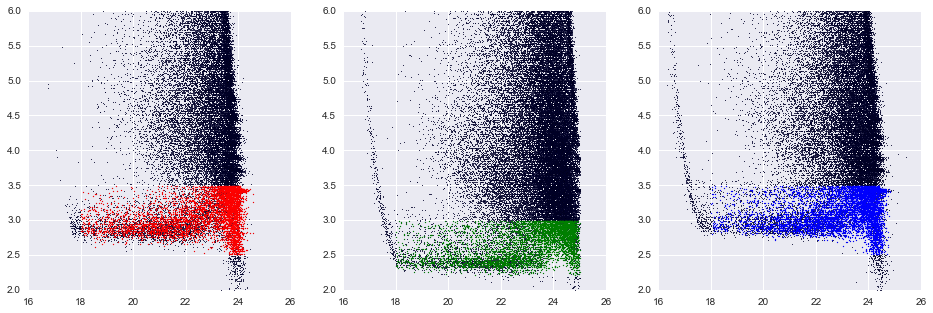

In [6]:
fig,ax = plt.subplots(1,3,figsize=(16,5))
ax[0].scatter(catalog_1_detected_only['i_mag'],catalog_1_detected_only['i_fwhm'],s=0.5)
ax[0].scatter(catalog_1_cut['i_mag'],catalog_1_cut['i_fwhm'],s=1,color='red')
ax[0].set_xlim(16,26)
ax[0].set_ylim(2,6)

ax[1].scatter(catalog_2_detected_only['i_mag'],catalog_2_detected_only['i_fwhm'],s=0.5)
ax[1].scatter(catalog_2_cut['i_mag'],catalog_2_cut['i_fwhm'],s=1,color='green')
ax[1].set_xlim(16,26)
ax[1].set_ylim(2,6)

ax[2].scatter(catalog_3_detected_only['i_mag'],catalog_3_detected_only['i_fwhm'],s=0.5)
ax[2].scatter(catalog_3_cut['i_mag'],catalog_3_cut['i_fwhm'],s=1,color='blue')
ax[2].set_xlim(16,26)
ax[2].set_ylim(2,6)

In [7]:
n4486_data = pd.read_csv('n4486_phot_combined.csv')
all_detected = (n4486_data['g_mag'] < 90) & (n4486_data['r_mag'] < 90) & (n4486_data['i_mag'] < 90)
n4486_data = n4486_data.ix[all_detected,:]

size_1 = n4486_data.ix[(n4486_data['i_fwhm'] < 5.0) & (n4486_data['i_fwhm'] > 3.9)]

In [8]:
comp = p.load(open('../ngvs_bg_2/ngvs_bg_2_i_completeness.p','rb'),encoding='latin1')

In [9]:
fg_mag_kde = KernelDensity(bandwidth=0.15)
fit = fg_mag_kde.fit(catalog_2_cut['i_mag'].reshape(-1,1))

In [10]:
fg_mag_kde_cv = KernelDensity()
parameters = {'bandwidth':[0.0,0.05,0.07,0.09,0.1,0.11,0.13,0.15]}

clf = GridSearchCV(fg_mag_kde_cv, parameters, cv=5)
clf.fit(catalog_2_cut['i_mag'].reshape(-1,1))

KeyboardInterrupt: 

In [133]:
for (params,mean_score) in zip(clf.cv_results_['params'],clf.cv_results_['mean_test_score']):
    print(params,mean_score)
    
print(clf.best_estimator_)

{'bandwidth': 0.0} nan
{'bandwidth': 0.05} -1713.97125928
{'bandwidth': 0.07} -1712.82428966
{'bandwidth': 0.09} -1712.60814608
{'bandwidth': 0.1} -1712.8332537
{'bandwidth': 0.11} -1713.2654463
{'bandwidth': 0.13} -1714.67338607
{'bandwidth': 0.15} -1716.67520953
KernelDensity(algorithm='auto', atol=0, bandwidth=0.09, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)


In [11]:
grid_size = 0.01
grid = np.arange(16,26,grid_size)
proba = np.exp(fg_mag_kde.score_samples(grid.reshape(-1,1)) / comp.predict_proba(grid.reshape(-1,1))[:,1])
norm = np.sum(proba * grid_size)

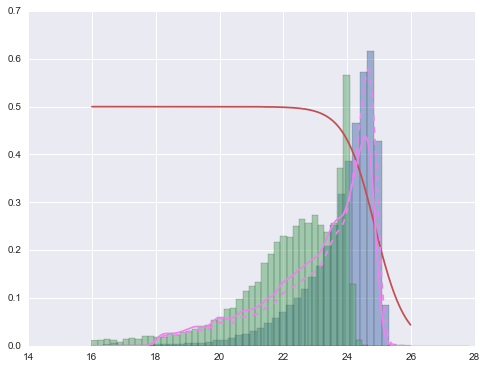

In [140]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
hist_a = ax.hist(catalog_2_i['i_mag'],bins=50,alpha=0.5,normed=True)
hist_b = ax.hist(size_1['i_mag'],alpha=0.5,bins=50,normed=True)
x = np.arange(16,29,0.01)
x = x.reshape(x.shape[0],1)
ax.plot(grid,comp.predict_proba(grid.reshape(-1,1))[:,1] * 0.5)
ax.plot(grid,np.exp(fg_mag_kde.score_samples(grid.reshape(-1,1))),color='violet')
ax.plot(grid,np.exp(fg_mag_kde.score_samples(grid.reshape(-1,1))) / comp.predict_proba(grid.reshape(-1,1))[:,1]
        * norm,color='violet',ls='--')

In [142]:
with open("ngvs_bg2_i_fg_mag_kde.p", "wb") as output_file:
    p.dump(fg_mag_kde, output_file)

(-0.2, 0.7)

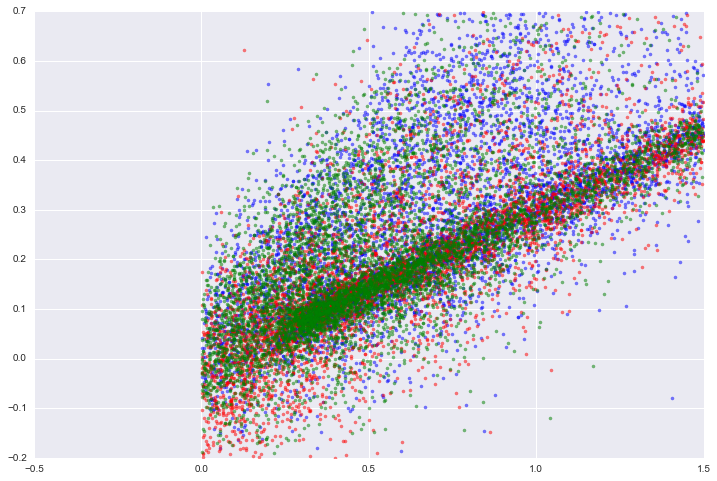

In [11]:
fig,ax = plt.subplots(figsize=(12,8))


ax.scatter(catalog_1_cut['g_mag'] - catalog_1_cut['i_mag'],\
            catalog_1_cut['r_mag'] - catalog_1_cut['i_mag'],s=10.,color='blue',alpha=0.5)
ax.scatter(catalog_2_cut['g_mag'] - catalog_2_cut['i_mag'],\
            catalog_2_cut['r_mag'] - catalog_2_cut['i_mag'],s=10.,color='red',alpha=0.5)
ax.scatter(catalog_3_cut['g_mag'] - catalog_3_cut['i_mag'],\
            catalog_3_cut['r_mag'] - catalog_3_cut['i_mag'],s=10.,color='green',alpha=0.5)

ax.set_xlim(-0.5,1.5)
ax.set_ylim(-0.2,0.7)

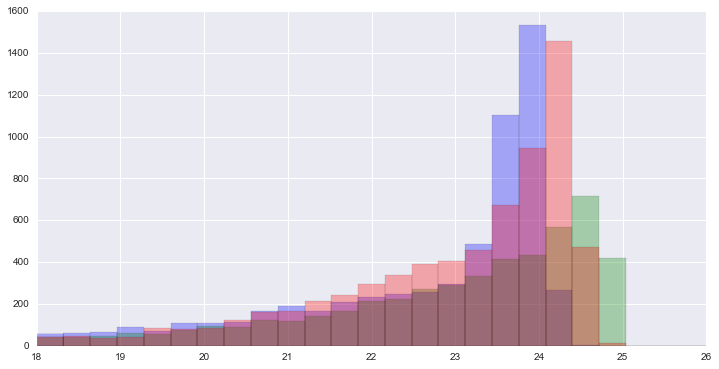

In [13]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
hist = ax.hist(catalog_1_cut['i_mag'],bins=25,range=(18,26),color='blue',alpha=0.3)
hist = ax.hist(catalog_2_cut['i_mag'],bins=25,range=(18,26),color='green',alpha=0.3)
hist = ax.hist(catalog_3_cut['i_mag'],bins=25,range=(18,26),color='red',alpha=0.3)

In [14]:
stack_catalogs = pd.concat([catalog_1_cut,catalog_2_cut,catalog_3_cut])

In [16]:
gi = stack_catalogs['g_mag'] - stack_catalogs['i_mag']
ri = stack_catalogs['r_mag'] - stack_catalogs['i_mag']

In [17]:
train_data = np.vstack([gi,ri]).T

In [18]:
#train a 2D kernel density estimate
kd = KernelDensity(bandwidth=0.05)
kd.fit(train_data)

KernelDensity(algorithm='auto', atol=0, bandwidth=0.05, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

### Now that basic KDE is trained, use some simple CV searches to find best bandwidth parameter 

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
kde_cv = KernelDensity()
parameters = {'bandwidth':[0.01,0.02,0.03,0.04,0.05,0.06,0.07]}

clf = GridSearchCV(kde_cv, parameters, cv=5)
clf.fit(train_data)

GridSearchCV(cv=5, error_score='raise',
       estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'bandwidth': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [97]:
for (params,mean_score) in zip(clf.cv_results_['params'],clf.cv_results_['mean_test_score']):
    print(params,mean_score)
    
print(clf.best_estimator_)

{'bandwidth': 0.01} 1731.84659302
{'bandwidth': 0.02} 1893.83906196
{'bandwidth': 0.03} 1855.67687191
{'bandwidth': 0.04} 1778.35819812
{'bandwidth': 0.05} 1684.95027225
{'bandwidth': 0.06} 1583.14966073
{'bandwidth': 0.07} 1476.17320069
KernelDensity(algorithm='auto', atol=0, bandwidth=0.02, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)


In [47]:
X, Y = np.meshgrid(np.arange(0,1.51,0.01),np.arange(-0.2,0.71,0.01))

xy = np.vstack([X.ravel(), Y.ravel()]).T

In [71]:
#train a 2D kernel density estimate
kd = KernelDensity(bandwidth=0.1)
kd.fit(train_data)

KernelDensity(algorithm='auto', atol=0, bandwidth=0.1, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

In [72]:
scores=np.exp(kd.score_samples(xy))
Z = scores.reshape(X.shape)
levels = np.linspace(0, Z.max(), 50)


(-0.2, 0.7)

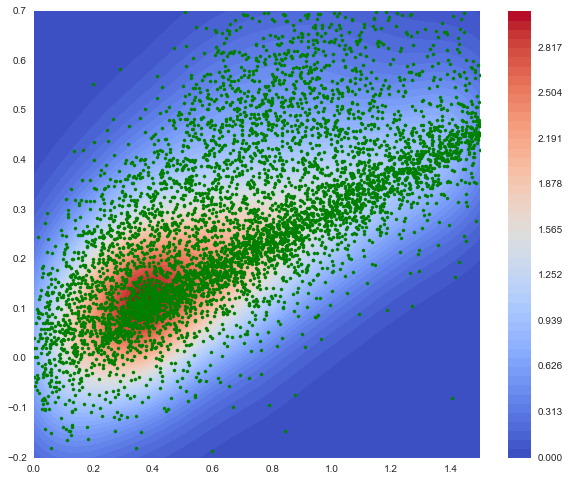

In [73]:
fig,ax = plt.subplots(figsize=(10,8))
contour = ax.contourf(X, Y, Z, levels=levels, cmap=plt.cm.coolwarm)
ax.scatter(catalog_1_cut['g_mag'] - catalog_1_cut['i_mag'],\
            catalog_1_cut['r_mag'] - catalog_1_cut['i_mag'],s=10,color='green')
plt.colorbar(contour)
ax.set_xlim(0.0,1.5)
ax.set_ylim(-0.2,0.7)

#plt.scatter(n3115_good['g_mag'] - n3115_good['i_mag'],n3115_good['r_mag'] - n3115_good['i_mag']+0.04,s=10,color='blue')

In [74]:
import pickle as p

In [75]:
with open("ngvs_bg_trimmed_kde_full_bw.1.p", "wb") as output_file:
    p.dump(kd, output_file)

In [123]:
n3115 = pd.read_csv('../n3115/n3115_pt_sources_jacob.csv')
n3115_good = n3115[((n3115['g_mag'] - n3115['i_mag']) < 1.5) & ((n3115['g_mag'] - n3115['i_mag']) > 0.0) &
                   ((n3115['r_mag'] - n3115['i_mag']) < 1.0) & ((n3115['r_mag'] - n3115['i_mag']) > -0.5)]

(-0.5, 0.7)

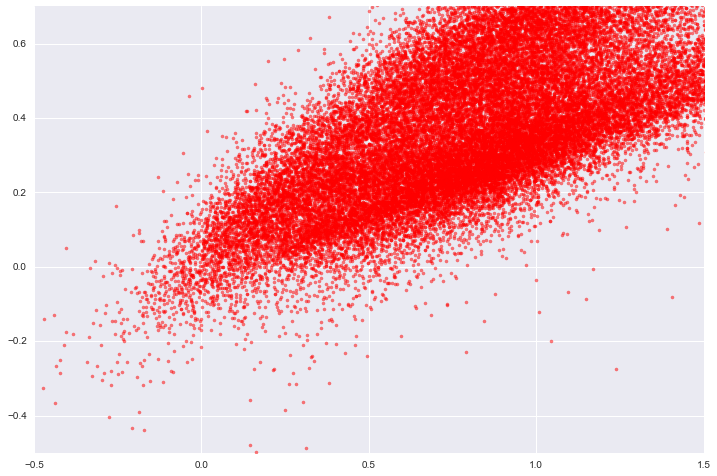

In [17]:
fig,ax = plt.subplots(figsize=(12,8))


#ax.scatter(catalog_1['g_mag'] - catalog_1['i_mag'],\
#            catalog_1['r_mag'] - catalog_1['i_mag'],s=10.,color='blue',alpha=0.5)
ax.scatter(catalog_1_detected_only['g_mag'] - catalog_1_detected_only['i_mag'],\
            catalog_1_detected_only['r_mag'] - catalog_1_detected_only['i_mag'],s=10.,color='red',alpha=0.5)
#ax.scatter(catalog_3['g_mag'] - catalog_3['i_mag'],\
#            catalog_3['r_mag'] - catalog_3['i_mag'],s=10.,color='green',alpha=0.5)

ax.set_xlim(-0.5,1.5)
ax.set_ylim(-0.5,0.7)